# Paper Title : Perceptual Losses for Real-Time Style Transfer and Super-Resolution
- Authors: Justin Johnson, Alexandre Alahi, Li Fei-Fei
- Johnson, J., & Alahi, A. (2016). Perceptual Losses for Real-Time Style Transfer and Super-Resolution. ArXiv. https://arxiv.org/abs/1603.08155

In [1]:
class Config:
    style_image = None
    dataset_path = None
    content_layers=['block5_conv2']
    style_layers=['block1_conv1',
                 'block2_conv1',
                 'block3_conv1',
                 'block4_conv1',
                 'block5_conv1']
    style_weight = 0.5
    content_weight = 10
    total_variation_weight = 0.004
    max_dim = 256
    epochs = 1
    batch_size = 8
    num_train_images = None
    checkpoint_path = "./model.keras"

In [2]:
import time
import os
import keras
import numpy as np
import tensorflow as tf
import tensorflow.keras.applications as app
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras.models import load_model, Model
from PIL import Image
from typing import Dict, List
from pathlib import Path

matplotlib.rcParams['figure.figsize'] = (12,12)
matplotlib.rcParams['axes.grid'] = False

In [3]:
# tf.keras.mixed_precision.set_global_policy('mixed_float16')
# print("Mixed Precision Activated")
try:
    tf.config.optimizer.set_jit(True)
    print("JIT activated")
except:
    pass

strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

JIT activated
Number of devices: 2


In [4]:
'''
Class to process images operation include loading images, 
normalization, denormalization and show images
'''
class ImageProcessor:
    def load_image(self, 
                   image_path: str, 
                   max_dim=512, 
                   normalize=False, 
                   force_resize=False):
        img = Image.open(image_path)
        img = img.convert("RGB")
        if force_resize:
            img = img.resize([max_dim, max_dim])
        else:
            img.thumbnail([max_dim, max_dim])
        img = np.array(img, dtype=np.float32)
        if normalize:
            img = img / 255.0
        img = np.expand_dims(img, axis=0)
        return img
        
    def deprocess_image(self, img: np.array):
        img = 255 * img
        return img

    def array_to_img(self, array: np.array, deprocessing=False):
        if deprocessing:
            array = self.deprocess_image(array)
        if np.ndim(array) > 3:
            assert array.shape[0] == 1
            array = array[0]
        array = np.clip(array, 0, 255)
        return Image.fromarray(np.array(array,dtype=np.uint8))
        
    def show(self, img: np.array, deprocessing=False):
        image = self.array_to_img(img, deprocessing)
        display.display(image)

In [5]:
class FeatureModel:
    def __init__(self, feat_layers_name: Dict[str, List[str]], model_name="vgg19"):
        if not("style" in feat_layers_name.keys() or "content" in feat_layers_name.keys()):
            raise Exception("Feature layers name dict should have 'style' and 'content' list")
            
        if model_name == "vgg16":
            feature_model = app.vgg16.VGG16(weights='imagenet', include_top=False)
            preprocess_fn = app.vgg16.preprocess_input
        elif model_name == "vgg19":
            feature_model = app.vgg19.VGG19(weights='imagenet', include_top=False)
            preprocess_fn = app.vgg19.preprocess_input
        else:
            feature_model = None
            preprocess_fn = None
            raise Exception(f"{model_name} not defined choices are ['vgg16', 'vgg19']")
            
        feature_model.trainable = False
        style_features = feat_layers_name["style"]
        content_features = feat_layers_name["content"]
        layer_names = style_features + content_features
        outputs = [feature_model.get_layer(name).output for name in layer_names]
        new_model = Model(inputs=feature_model.input, outputs=outputs, name="feature_model")
        del feature_model
        self.model = new_model
        self.preprocess_input = preprocess_fn
        self.style_features = style_features
        self.content_features = content_features

    def summary(self):
        self.model.summary()

    def __call__(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = self.preprocess_input(inputs)
        outputs = self.model(preprocessed_input)
        style_length = len(self.style_features)
        style_output, content_output = outputs[:style_length], outputs[style_length:]
        content_dict = {name:value 
                        for name, value in zip(self.content_features, content_output)}
        style_dict = {name:value 
                      for name, value in zip(self.style_features, style_output)}
        return {'content':content_dict, 'style':style_dict}

In [6]:
class NSTLoss:
    def __init__(self, content_weight=1, style_weight=1):
        self.alpha = content_weight
        self.beta = style_weight
        
    def content_loss(self, y_pred, y_content):
        return tf.reduce_mean(tf.square(y_pred - y_content))

    def __gram_matrix(self, x):
        gram=tf.linalg.einsum('bijc,bijd->bcd', x, x)
        return gram/tf.cast(x.shape[1]*x.shape[2], x.dtype)
        
    def style_loss(self, y_pred, y_style):
        return tf.reduce_mean(tf.square(self.__gram_matrix(y_pred) - 
                                        self.__gram_matrix(y_style)))
        
    def __call__(self, y_pred, y_content, y_style):
        pred_content= y_pred["content"]
        pred_style= y_pred["style"]
        content_loss = tf.add_n([self.content_loss(pred_content[name], y_content[name]) 
                                 for name in pred_content.keys()])/len(pred_content)
        style_loss = tf.add_n([self.style_loss(pred_style[name], y_style[name]) 
                               for name in pred_style.keys()])/len(pred_style)
        return (self.alpha * content_loss) + (self.beta * style_loss)

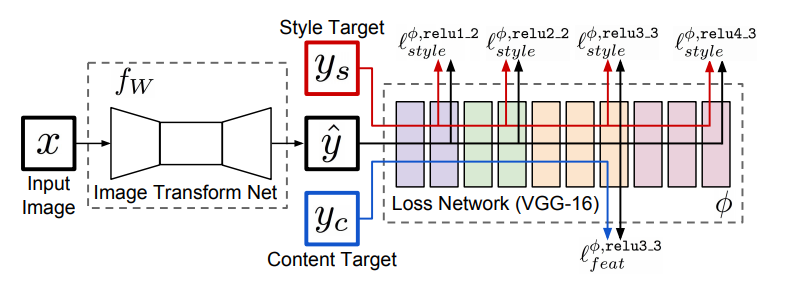

In [7]:
'''
All Neural Network Layers implementation required
'''
@keras.saving.register_keras_serializable(package="Custom")
class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.padding = tuple(padding)
        
    def call(self, input_tensor):
        padding_width, padding_height = self.padding
        return tf.pad(input_tensor, 
                      [[0,0],
                       [padding_height, 
                        padding_height],         
                       [padding_width, 
                        padding_width], 
                       [0,0] ], 
                      'REFLECT')
    def get_config(self):
        config = super().get_config()
        config.update({"padding": self.padding})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


@keras.saving.register_keras_serializable(package="Custom")
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-3, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        channels = input_shape[-1]
        self.scale = self.add_weight(
            shape=(channels,), initializer="ones", trainable=True, name="scale"
        )
        self.shift = self.add_weight(
            shape=(channels,), initializer="zeros", trainable=True, name="shift"
        )

    def call(self, inputs):
        mu, var = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mu) / tf.sqrt(var + self.epsilon)
        return self.scale * normalized + self.shift

    def get_config(self):
        config = super().get_config()
        config.update({"epsilon": self.epsilon})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

@keras.saving.register_keras_serializable(package="Custom")
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, **kwargs):
        super(ConvLayer,self).__init__(**kwargs)
        self.padding=ReflectionPadding2D([k//2 for k in kernel_size])
        self.conv2d=tf.keras.layers.Conv2D(filters,kernel_size,strides)
        self.bn=InstanceNormalization()
        
    def call(self, inputs):
        x=self.padding(inputs)
        x=self.conv2d(x)
        x=self.bn(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.conv2d.filters, "kernel_size": self.conv2d.kernel_size})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

@keras.saving.register_keras_serializable(package="Custom")
class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ResidualLayer, self).__init__(**kwargs)
        self.conv2d_1=ConvLayer(filters, kernel_size)
        self.conv2d_2=ConvLayer(filters, kernel_size)
        self.relu=tf.keras.layers.ReLU()
        self.add=tf.keras.layers.Add()
        
    def call(self, inputs):
        residual=inputs
        x=self.conv2d_1(inputs)
        x=self.relu(x)
        x=self.conv2d_2(x)
        x=self.add([x, residual])
        return x

    def get_config(self):
        config = super().get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

@keras.saving.register_keras_serializable(package="Custom")
class UpsampleLayer(tf.keras.layers.Layer):
    def __init__(self,filters, kernel_size, strides=1, upsample=2, **kwargs):
        super(UpsampleLayer, self).__init__(**kwargs)
        self.upsample=tf.keras.layers.UpSampling2D(size=upsample)
        self.padding=ReflectionPadding2D([k//2 for k in kernel_size])
        self.conv2d=tf.keras.layers.Conv2D(filters, kernel_size, strides)
        self.bn=InstanceNormalization()
        
    def call(self, inputs):
        x=self.upsample(inputs)
        x=self.padding(x)
        x=self.conv2d(x)
        return self.bn(x)

    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.conv2d.filters, "kernel_size": self.conv2d.kernel_size})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [8]:
@keras.saving.register_keras_serializable(package="Custom")
class NSTModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super(NSTModel, self).__init__(**kwargs)
        self.conv2d_1 = ConvLayer(
            filters=32, kernel_size=(9, 9), strides=1, name="conv2d_1_32"
        )
        self.conv2d_2 = ConvLayer(
            filters=64, kernel_size=(3, 3), strides=2, name="conv2d_2_64"
        )
        self.conv2d_3 = ConvLayer(
            filters=128, kernel_size=(3, 3), strides=2, name="conv2d_3_128"
        )
        self.res_1 = ResidualLayer(filters=128, kernel_size=(3, 3), name="res_1_128")
        self.res_2 = ResidualLayer(filters=128, kernel_size=(3, 3), name="res_2_128")
        self.res_3 = ResidualLayer(filters=128, kernel_size=(3, 3), name="res_3_128")
        self.res_4 = ResidualLayer(filters=128, kernel_size=(3, 3), name="res_4_128")
        self.res_5 = ResidualLayer(filters=128, kernel_size=(3, 3), name="res_5_128")
        self.deconv2d_1 = UpsampleLayer(
            filters=64, kernel_size=(3, 3), name="deconv2d_1_64"
        )
        self.deconv2d_2 = UpsampleLayer(
            filters=32, kernel_size=(3, 3), name="deconv2d_2_32"
        )
        self.deconv2d_3 = ConvLayer(
            filters=3, kernel_size=(9, 9), strides=1, name="deconv2d_3_3"
        )
        self.relu = tf.keras.layers.ReLU()

    def call(self, inputs):
        x = self.conv2d_1(inputs)
        x = self.relu(x)
        x = self.conv2d_2(x)
        x = self.relu(x)
        x = self.conv2d_3(x)
        x = self.relu(x)
        x = self.res_1(x)
        x = self.res_2(x)
        x = self.res_3(x)
        x = self.res_4(x)
        x = self.res_5(x)
        x = self.deconv2d_1(x)
        x = self.relu(x)
        x = self.deconv2d_2(x)
        x = self.relu(x)
        x = self.deconv2d_3(x)
        x = (tf.nn.tanh(x) + 1) * (255.0 / 2)
        return x

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [9]:
class TensorflowDatasetLoader:
    def __init__(self, 
                 dataset_path, 
                 batch_size=4, 
                 image_size=(256, 256),
                 normalize=False,
                 num_images=None):
        images_paths = [str(path) for path in Path(dataset_path).glob("*.jpg")]
        self.length = len(images_paths)
        if num_images is not None:
            images_paths = images_paths[0:num_images]
        dataset = tf.data.Dataset.from_tensor_slices(images_paths).map(
            lambda path: self.load_tf_image(path, dim=image_size, normalize=normalize),
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
        dataset = dataset.batch(batch_size, drop_remainder=True)
        # dataset = dataset.shuffle(buffer_size=1000, seed=111)
        dataset = dataset.cache()
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        self.dataset = dataset
        
    def __len__(self):
        return self.length
        
    def load_tf_image(self, 
                      image_path, 
                      dim, 
                      normalize=False):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image= tf.image.resize(image,dim)
        if normalize:
            image= image / 255.0
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image

In [10]:
class NSTStep:
    def __init__(self, 
                 style_image: np.array,
                 feature_model: FeatureModel,
                 optimizer: tf.keras.optimizers,
                 content_weight: float, 
                 style_weight: float,
                 total_variation_weight: float):
        self.feature_model = feature_model
        self.optimizer = optimizer
        self.alpha = content_weight
        self.beta = style_weight
        self.gamma = total_variation_weight
        self.nst_loss = NSTLoss(self.alpha, self.beta)
        self.style_feats = feature_model(style_image)["style"]
        
    def __call__(self, nst_model: NSTModel, images):
        content_acts = self.feature_model(images)["content"]
        with tf.GradientTape() as tape:
            gen_images = nst_model(images)
            gen_images = tf.clip_by_value(gen_images, 0, 255)
            outputs = self.feature_model(gen_images / 255.0)
            loss = self.nst_loss(outputs, content_acts, self.style_feats)
            loss += self.gamma * tf.image.total_variation(gen_images)
        grad = tape.gradient(loss, nst_model.trainable_variables)
        self.optimizer.apply_gradients(zip(grad, nst_model.trainable_variables))
        return nst_model, loss

In [11]:
def train_nst(config, image_processor, feature_model, optimizer, strategy=None, verbose=1000):
    loader = TensorflowDatasetLoader(config.dataset_path, 
                                     batch_size=config.batch_size,
                                     image_size=[config.max_dim, config.max_dim],
                                     normalize=True,
                                     num_images=config.num_train_images)
    
    style_image = image_processor.load_image(config.style_image, 
                                             max_dim=config.max_dim, 
                                             normalize=True,
                                             force_resize=True)
    image_processor.show(style_image, deprocessing=True)

    if strategy is not None:
        with strategy.scope():
            nst_model = NSTModel()
    else:
        nst_model = NSTModel()

    nst_step = NSTStep(style_image=style_image, 
                       feature_model=feature_model,
                       optimizer=optimizer,
                       content_weight=config.content_weight,
                       style_weight=config.style_weight,
                       total_variation_weight=config.total_variation_weight
                      )
    losses = []
    counter = 0
    print("Model Checkpoint Path: ", config.checkpoint_path)
    for epoch in range(config.epochs):
        batch_losses = []
        for images in loader.dataset:
            nst_model, loss = nst_step(nst_model, images)
            batch_losses.append(loss)
            if counter > verbose:
                counter = 0
                print(f"Epoch: {epoch + 1} | Loss: {tf.reduce_mean(batch_losses).numpy()}")
            counter += 1
        losses.append(tf.reduce_mean(batch_losses).numpy())
        nst_model.save(config.checkpoint_path)
    return nst_model, losses

In [12]:
config = Config()
image_processor = ImageProcessor()

In [13]:
feature_model = FeatureModel({"content": config.content_layers, 
                              "style": config.style_layers},
                             model_name = "vgg16"
                            )
feature_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "feature_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,354,880 (47.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,354,880 (47.13 MB)

In [14]:
nst_model = NSTModel()
nst_model.summary()

Model: "nst_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1_32 (ConvLayer)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2_64 (ConvLayer)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3_128 (ConvLayer)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_1_128 (ResidualLayer)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_2_128 (ResidualLayer)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_3_128 (ResidualLayer)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_4_128 (ResidualLayer)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_5_128 (ResidualLayer)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv2d_1_64 (UpsampleLayer)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv2d_2_32 (UpsampleLayer)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv2d_3_3 (ConvLayer)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
del nst_model

In [16]:
# updating default configs
config.dataset_path = "/kaggle/input/gan-getting-started/photo_jpg"
config.style_image = "/kaggle/input/nst-content-styles/style_12.jpg"
config.style_weight = 1e-3
config.content_weight = 5e3
config.total_variation_weight = 0.0004
config.max_dim = 256

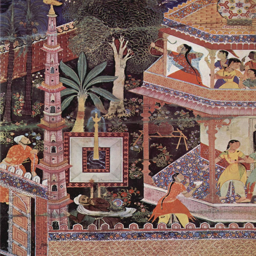

Model Checkpoint Path:  ./model.keras
Epoch: 1 | Loss: 7308361.5
Epoch: 1 | Loss: 5473603.0
Epoch: 1 | Loss: 4658472.0
Epoch: 1 | Loss: 4189579.75
Epoch: 1 | Loss: 3882818.25
Epoch: 1 | Loss: 3663627.75
Epoch: 1 | Loss: 3491241.5
Epoch: 1 | Loss: 3359089.0


In [17]:
optimizer = tf.optimizers.Adam(learning_rate=1e-3)
nst_model, losses = train_nst(config=config, 
                              image_processor=image_processor,
                              feature_model=feature_model,
                              optimizer=optimizer,
                              strategy=strategy,
                              verbose=100)

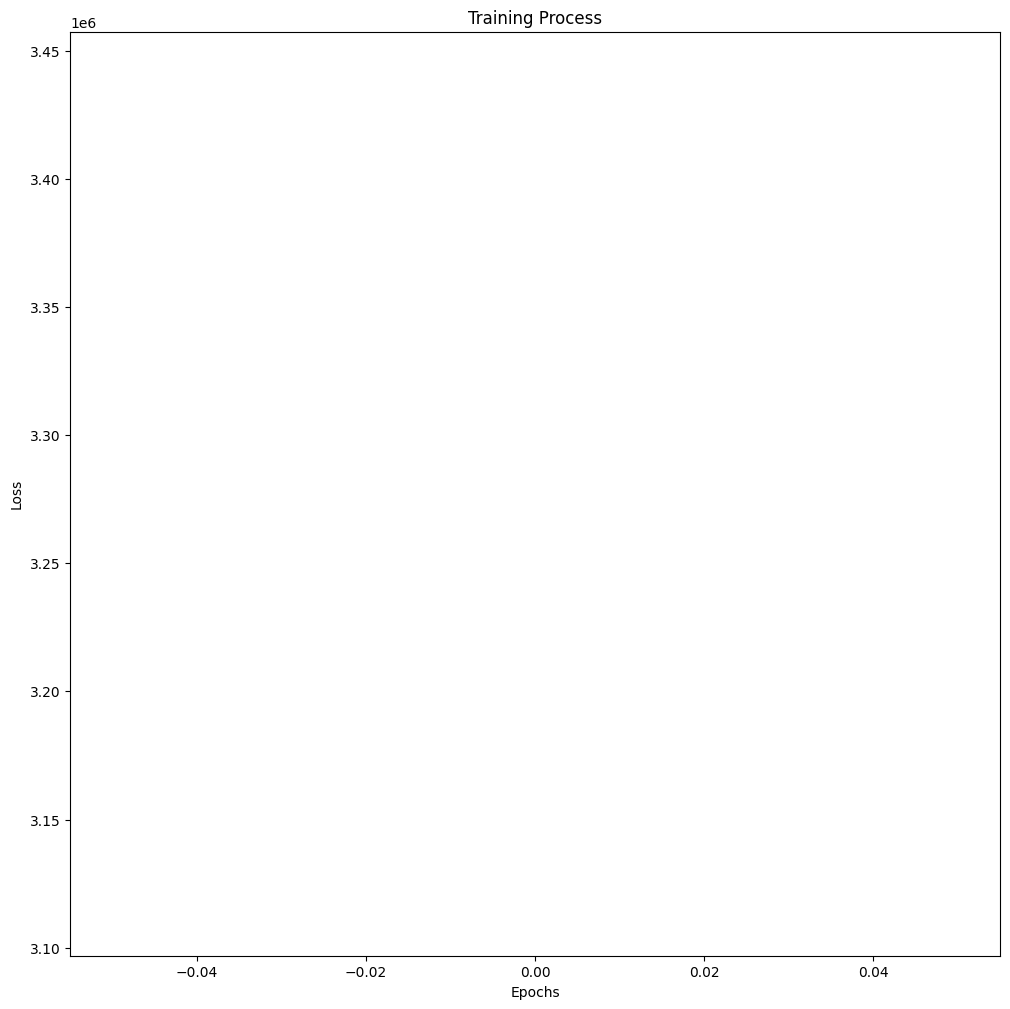

In [18]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Process")
plt.show()

In [19]:
del nst_model

In [20]:
nst_model = keras.saving.load_model(config.checkpoint_path)
print("Trained checkpoint Loaded")

Trained checkpoint Loaded


Test Image shape:  (1, 341, 512, 3)


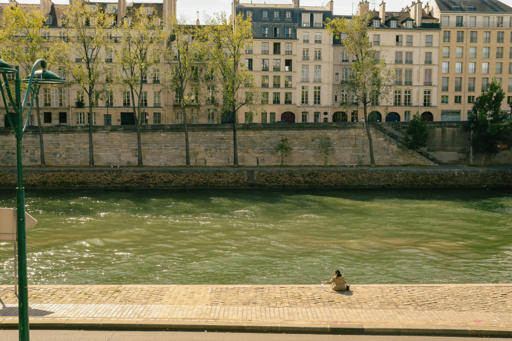

In [21]:
test_img_path = "/kaggle/input/nst-content-styles/neural_style_transfer/neural_style_transfer/images/content_3.jpg"
test_image = image_processor.load_image(test_img_path, 
                                        max_dim=config.max_dim*2, 
                                        normalize=True,
                                        force_resize=False)
print("Test Image shape: ", test_image.shape)
image_processor.show(test_image, deprocessing=True)

In [22]:
gen_image = nst_model(test_image)
print(gen_image.shape)

(1, 344, 512, 3)


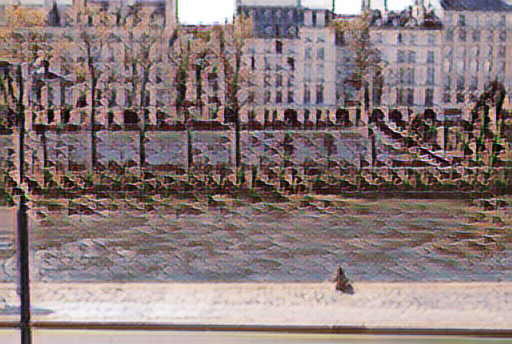

In [23]:
image_processor.show(gen_image.numpy(), deprocessing=False)

In [24]:
final_gen_image = image_processor.array_to_img(gen_image.numpy(), deprocessing=False)
final_gen_image.save('test_image_gen.jpg')